In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
#set a plot style
sns.set(style = "whitegrid")

In [3]:
#load the dataset
df = pd.read_csv("customer_segmentation_data.csv", encoding = 'unicode_escape')

In [4]:
#quick look at the dataset
print(df.shape)
print(df.head())
print(df.info())

(541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   

In [5]:
# Data Cleaning

#drop missing CustomerID
df = df.dropna(subset = ["CustomerID"])

#remove cancelled orders (InvoiceNo starting with "C")
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

#keep only positive quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

#create TotalPrice
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

#convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [6]:
# RFM Feature Engineering

#reference date = last invoice date
ref_date = df["InvoiceDate"].max()

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,  #recency
    "InvoiceNo": "nunique",  #frequency
    "TotalPrice": "sum"      #monetary
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

print(rfm.describe())

         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    91.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     0.000000     1.000000       3.750000
25%    13813.250000    17.000000     1.000000     307.415000
50%    15299.500000    50.000000     2.000000     674.485000
75%    16778.750000   141.000000     5.000000    1661.740000
max    18287.000000   373.000000   209.000000  280206.020000


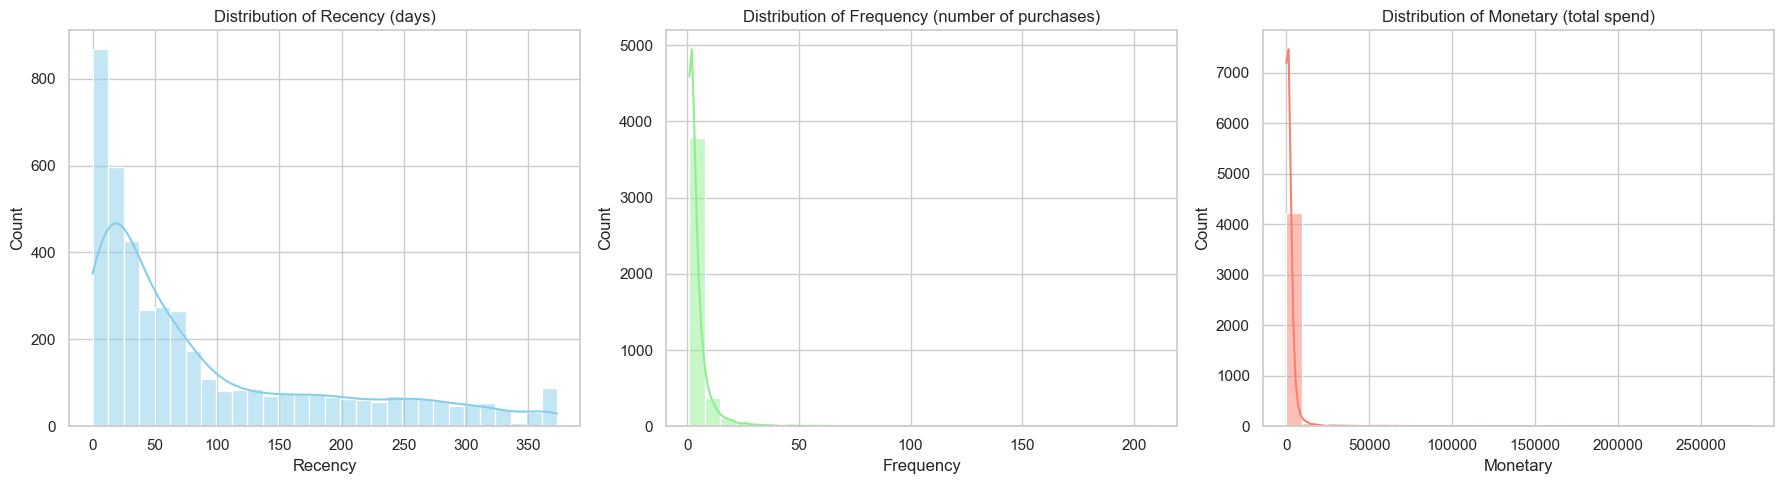

In [7]:
# Preprocessing

#check distributions of R, F, M

fig, axes = plt.subplots(1, 3, figsize = (18, 5))

sns.histplot(rfm["Recency"], bins = 30, kde = True, ax = axes[0], color = "skyblue")
axes[0].set_title("Distribution of Recency (days)")

sns.histplot(rfm["Frequency"], bins = 30, kde = True, ax = axes[1], color = "lightgreen")
axes[1].set_title("Distribution of Frequency (number of purchases)")

sns.histplot(rfm["Monetary"], bins = 30, kde = True, ax = axes[2], color = "salmon")
axes[2].set_title("Distribution of Monetary (total spend)")

plt.tight_layout()
plt.show()

C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


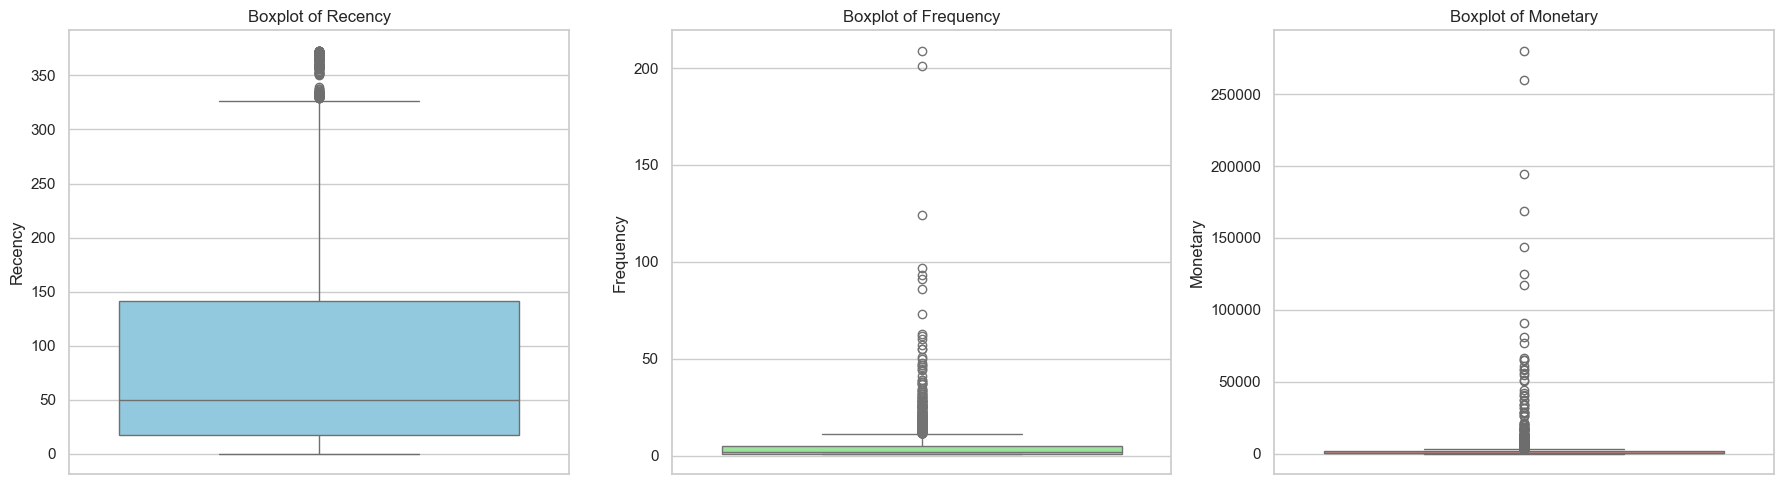

In [8]:
#boxplots for R, F, M to detect outliers

fig, axes = plt.subplots(1, 3, figsize = (18, 5))

sns.boxplot(y = rfm["Recency"], ax = axes[0], color = "skyblue")
axes[0].set_title("Boxplot of Recency")

sns.boxplot(y = rfm["Frequency"], ax = axes[1], color = "lightgreen")
axes[1].set_title("Boxplot of Frequency")

sns.boxplot(y = rfm["Monetary"], ax = axes[2], color = "salmon")
axes[2].set_title("Boxplot of Monetary")

plt.tight_layout()
plt.show()

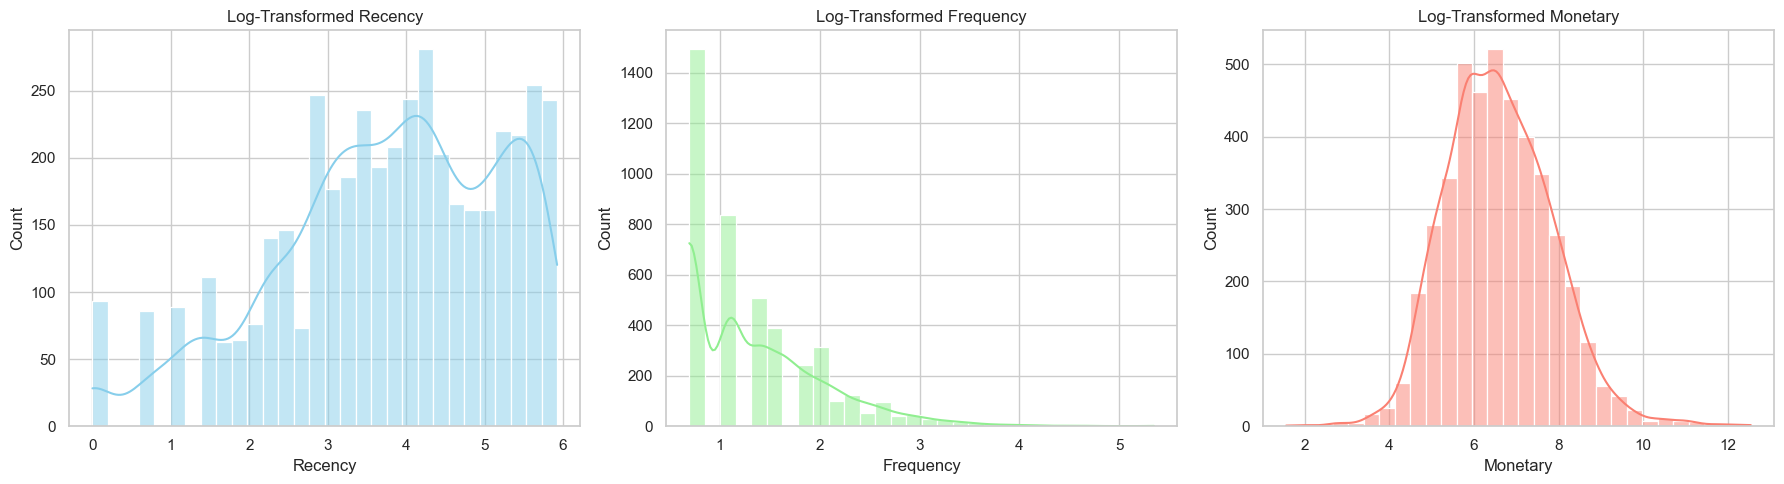

In [9]:
#apply log transform to reduce skewness
rfm_log = rfm.copy()
rfm_log["Recency"] = np.log1p(rfm_log["Recency"])
rfm_log["Frequency"] = np.log1p(rfm_log["Frequency"])
rfm_log["Monetary"] = np.log1p(rfm_log["Monetary"])

#plot distributions after log transform
fig, axes = plt.subplots(1, 3, figsize = (18, 5))

sns.histplot(rfm_log["Recency"], bins = 30, kde = True, ax = axes[0], color = "skyblue")
axes[0].set_title("Log-Transformed Recency")

sns.histplot(rfm_log["Frequency"], bins = 30, kde = True, ax = axes[1], color = "lightgreen")
axes[1].set_title("Log-Transformed Frequency")

sns.histplot(rfm_log["Monetary"], bins = 30, kde = True, ax = axes[2], color = "salmon")
axes[2].set_title("Log-Transformed Monetary")

plt.tight_layout()
plt.show()

C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


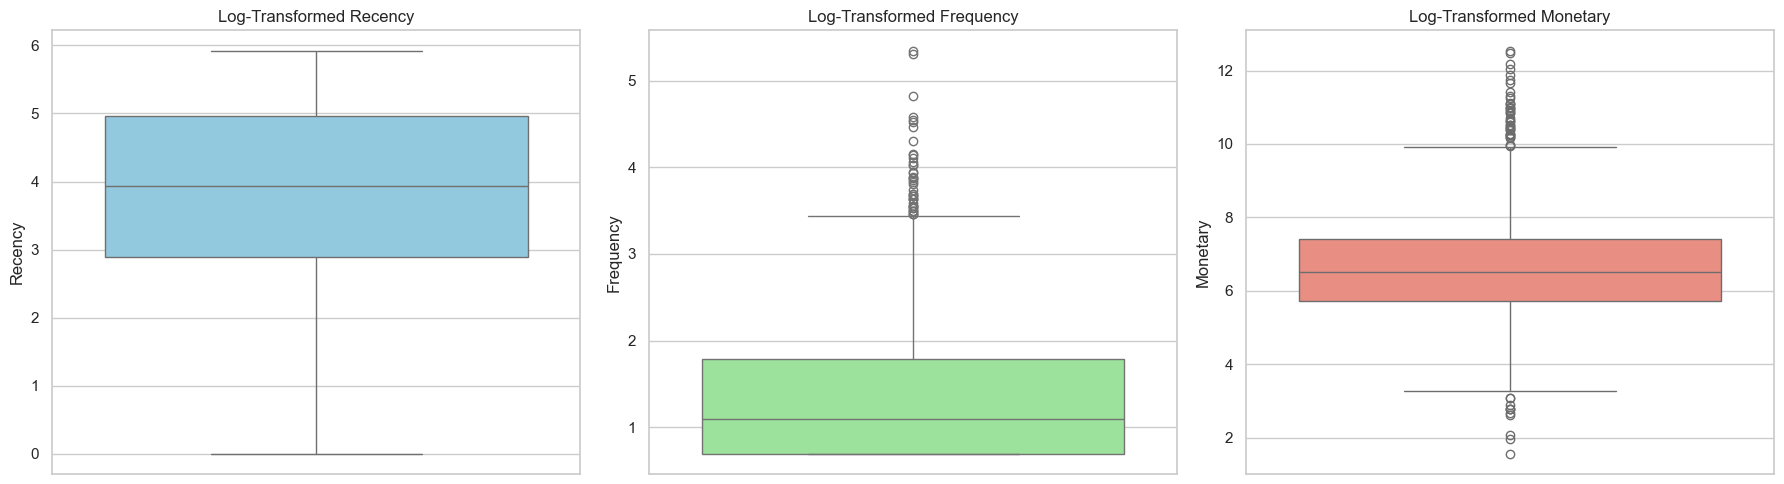

In [10]:
#boxplots after log-transform

fig, axes = plt.subplots(1, 3, figsize = (18, 5))

sns.boxplot(y = rfm_log["Recency"], ax = axes[0], color = "skyblue")
axes[0].set_title("Log-Transformed Recency")

sns.boxplot(y = rfm_log["Frequency"], ax = axes[1], color = "lightgreen")
axes[1].set_title("Log-Transformed Frequency")

sns.boxplot(y = rfm_log["Monetary"], ax = axes[2], color = "salmon")
axes[2].set_title("Log-Transformed Monetary")

plt.tight_layout()
plt.show()

In [11]:
X = rfm_log[["Recency", "Frequency", "Monetary"]]

#apply scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


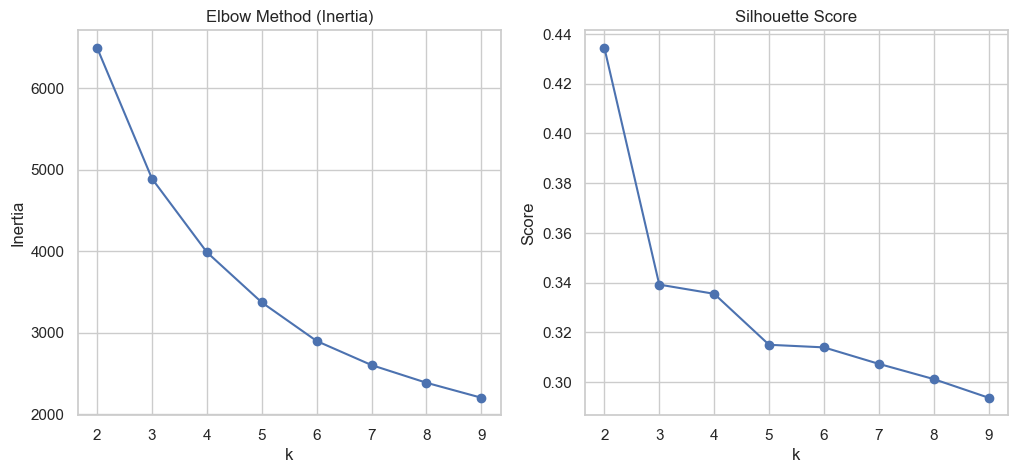

In [12]:
# Find Optimal Clusters (Elbow + Silhouette)

inertia = []
silhouette = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(range(2,10), inertia, marker = "o")
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(range(2,10), silhouette, marker = "o")
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")

plt.show()

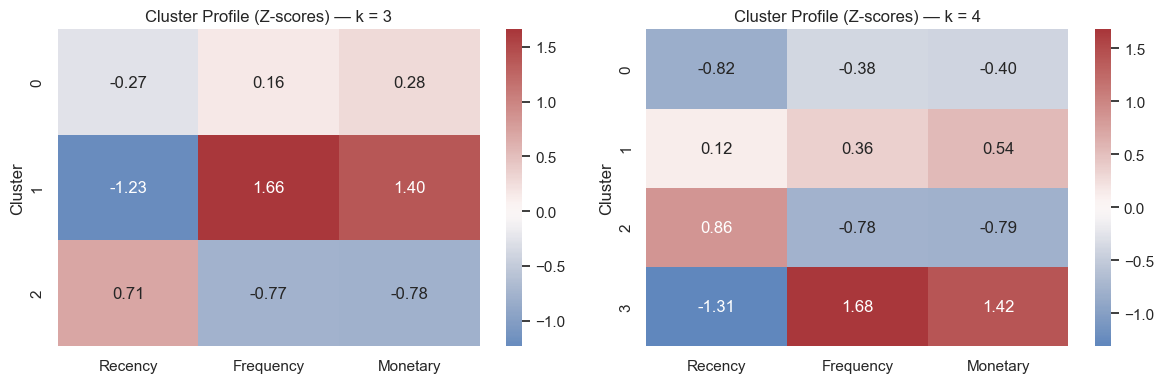


=== k=3 ===


,Count,Recency,Frequency,Monetary
0,1687,46.36,3.55,1405.56
1,731,12.94,13.65,8018.89
2,1920,161.16,1.34,353.34


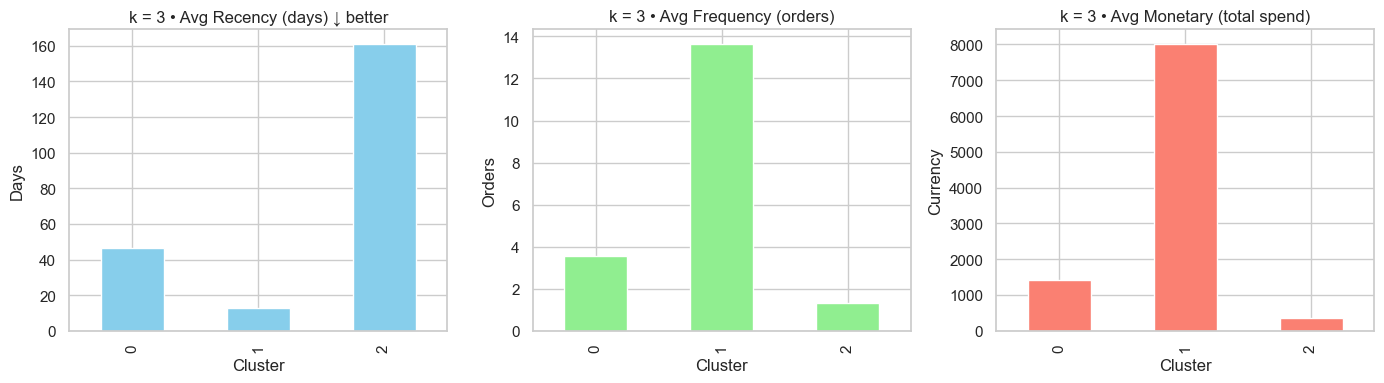


=== k=4 ===


,Count,Recency,Frequency,Monetary
0,808,17.14,2.11,545.19
1,1199,67.50,4.23,1838.55
2,1645,179.46,1.32,351.00
3,686,10.35,13.98,8293.13


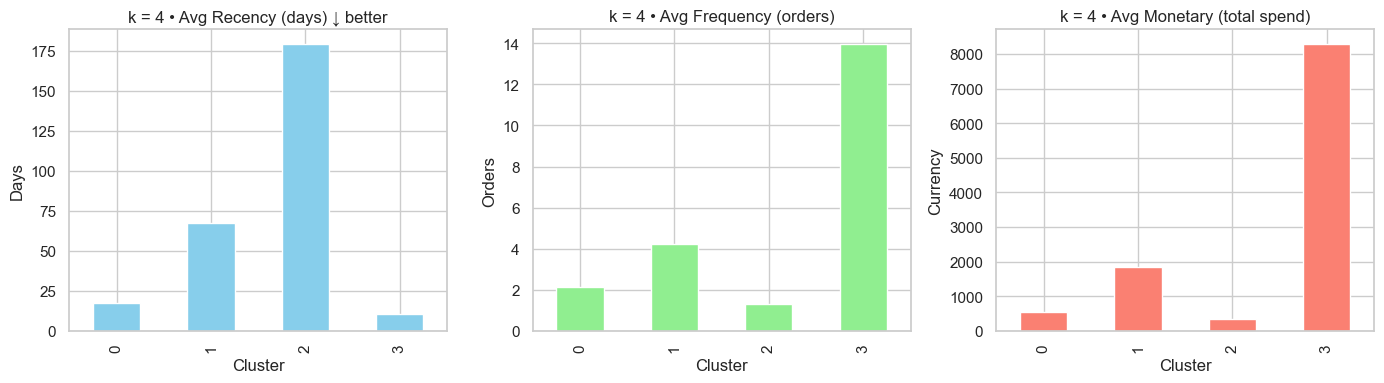

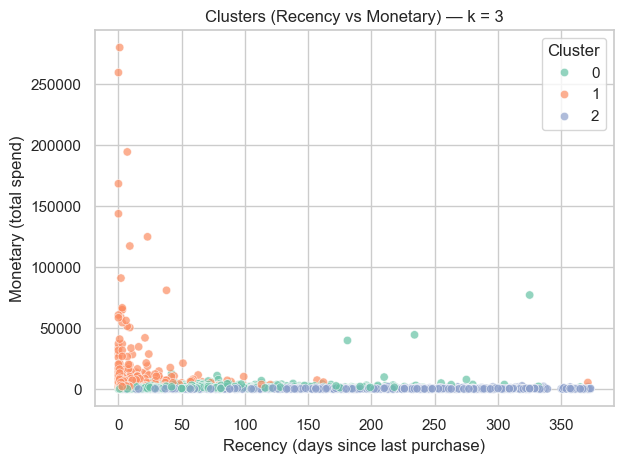

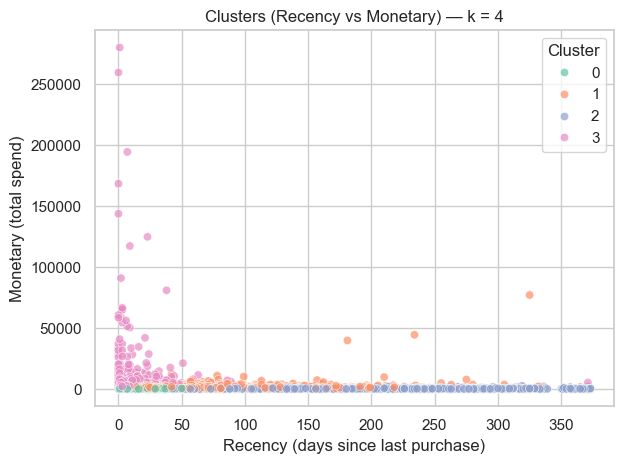

In [13]:
# Fit KMeans and Visualize Clusters

#helper: fit KMeans and build profiles
def run_kmeans_and_profiles(k, X_scaled, rfm, rfm_log):
    km = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    labels = km.fit_predict(X_scaled)

    #z-score cluster profile (mean of scaled features)
    z_profile = (
        pd.DataFrame(X_scaled, columns = ["Recency", "Frequency", "Monetary"])
        .assign(Cluster = labels)
        .groupby("Cluster").mean().round(2)
    )

    #raw (business units) profile
    raw_profile = (
        rfm.assign(Cluster = labels)[["Cluster", "Recency", "Frequency", "Monetary"]]
        .groupby("Cluster").mean().round(2)
    )

    counts = pd.Series(labels).value_counts().sort_index().rename("Count")

    return labels, z_profile, raw_profile, counts

#run for k = 3 and k = 4
k_list = [3, 4]
results = {}
for k in k_list:
    labels, z_prof, raw_prof, counts = run_kmeans_and_profiles(k, X_scaled, rfm, rfm_log)
    results[k] = {"labels": labels, "z": z_prof, "raw": raw_prof, "counts": counts}

#side-by-side z-score heatmaps
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
for ax, k in zip(axes, k_list):
    sns.heatmap(results[k]["z"], annot = True, cmap = "vlag", center = 0, fmt = ".2f", ax = ax)
    ax.set_title(f"Cluster Profile (Z-scores) — k = {k}")
    ax.set_ylabel("Cluster")
plt.tight_layout()
plt.savefig("images/zscore_heatmaps.png", dpi = 300, bbox_inches = "tight")
plt.show()

#bar charts of raw averages for each k
for k in k_list:
    raw_profile = results[k]["raw"]
    counts = results[k]["counts"]

    print(f"\n=== k={k} ===")
    display(pd.concat([counts, raw_profile], axis = 1))

    fig, axes = plt.subplots(1, 3, figsize = (14, 4))
    raw_profile["Recency"].plot(kind = "bar", ax = axes[0], color = "skyblue")
    axes[0].set_title(f"k = {k} • Avg Recency (days) ↓ better")
    axes[0].set_xlabel("Cluster"); axes[0].set_ylabel("Days")

    raw_profile["Frequency"].plot(kind = "bar", ax = axes[1], color = "lightgreen")
    axes[1].set_title(f"k = {k} • Avg Frequency (orders)")
    axes[1].set_xlabel("Cluster"); axes[1].set_ylabel("Orders")

    raw_profile["Monetary"].plot(kind = "bar", ax = axes[2], color = "salmon")
    axes[2].set_title(f"k = {k} • Avg Monetary (total spend)")
    axes[2].set_xlabel("Cluster"); axes[2].set_ylabel("Currency")

    plt.tight_layout()
    plt.savefig(f"images/barplots_k{k}.png", dpi = 300, bbox_inches = "tight")
    plt.show()

#scatter (Recency vs Monetary) for each k
for k in k_list:
    labels = results[k]["labels"]
    tmp = rfm.copy()
    tmp["Cluster"] = labels
    sns.scatterplot(data = tmp, x = "Recency", y = "Monetary", hue = "Cluster", palette = "Set2", alpha = 0.7)
    plt.title(f"Clusters (Recency vs Monetary) — k = {k}")
    plt.xlabel("Recency (days since last purchase)")
    plt.ylabel("Monetary (total spend)")
    plt.tight_layout()
    plt.savefig(f"images/scatter_k{k}.png", dpi = 300, bbox_inches = "tight")
    plt.show()